## Part 2: Business Analysis

**Author: John Min  
Date: November 24, 2019**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices

In [2]:
ls ../data/

LCDataDictionary.xlsx       loan.csv
database.sqlite             ~$LCDataDictionary.xlsx
lending-club-loan-data.zip


In [3]:
def compute_annualized_ror(r):
    '''Compute annualized rate of return for 36-month term loans'''
    return (r['total_pymnt'] / r['funded_amnt']) ** (1/3) - 1

In [4]:
cols = ['loan_amnt', 
        'funded_amnt', 
        'term', 
        'int_rate', 
        'grade', 
        'annual_inc', 
        'issue_d', 
        'dti', 
        'revol_bal', 
        'total_pymnt', 
        'loan_status'] 

data = pd.read_csv('../data/loan.csv', usecols = cols)\
    .query("term == ' 36 months'")\
    .assign(issue_year = lambda x: x['issue_d'].apply(lambda x: int(x.split('-')[1])))\
    .query("issue_year < 2016")\
    .assign(
        default_status = lambda x: (~x['loan_status'].str.contains('Fully Paid')).astype(int), #compute default status
        annualized_ror = lambda x: compute_annualized_ror(x)) # compute annualized rate of return

#### 2.1 What percentage of loans has been fully paid?

86.02% loans have been fully paid.

In [5]:
data['loan_status'].str.contains('Fully Paid').value_counts(normalize=True)

True     0.860199
False    0.139801
Name: loan_status, dtype: float64

#### 2.2 When bucketed by year of origination and grade, which cohort has the highest rate of defaults? Here you may assume that any loan which was not fully paid had "defaulted".

The 2007 G cohort had the highest rate of default at 48.57%.

In [6]:
def cohort_default_analysis(data: pd.DataFrame, cohort_features: list):
    
    cohorts = data.groupby(cohort_features)
    
    cohort_default_df = cohorts['default_status']\
    .value_counts(normalize=True)\
    .to_frame()\
    .rename(columns={'default_status': 'default_rate'})\
    .reset_index()\
    .query("default_status == 1")\
    .merge(
        cohorts['default_status']\
            .count()\
            .to_frame()\
            .rename(columns={'default_status': 'cohort_size'})\
            .reset_index(),
        on = cohort_features)\
    .sort_values(by='default_rate', ascending=False)
    return cohort_default_df

In [7]:
cohort_default_df = cohort_default_analysis(data, ['issue_year', 'grade'])\
    .assign(cohort = lambda x: x['issue_year'].apply(str) + '-' + x['grade'])

cohort_default_df.head(n=10)

,issue_year,grade,default_status,default_rate,cohort_size,cohort
6,2007,G,1,0.485714,35,2007-G
5,2007,F,1,0.480769,52,2007-F
62,2015,G,1,0.467742,248,2015-G
61,2015,F,1,0.424798,1363,2015-F
34,2011,G,1,0.400000,10,2011-G
55,2014,G,1,0.363128,179,2014-G
27,2010,G,1,0.352941,34,2010-G
12,2008,F,1,0.342342,111,2008-F
60,2015,E,1,0.329524,9450,2015-E
20,2009,G,1,0.327273,55,2009-G


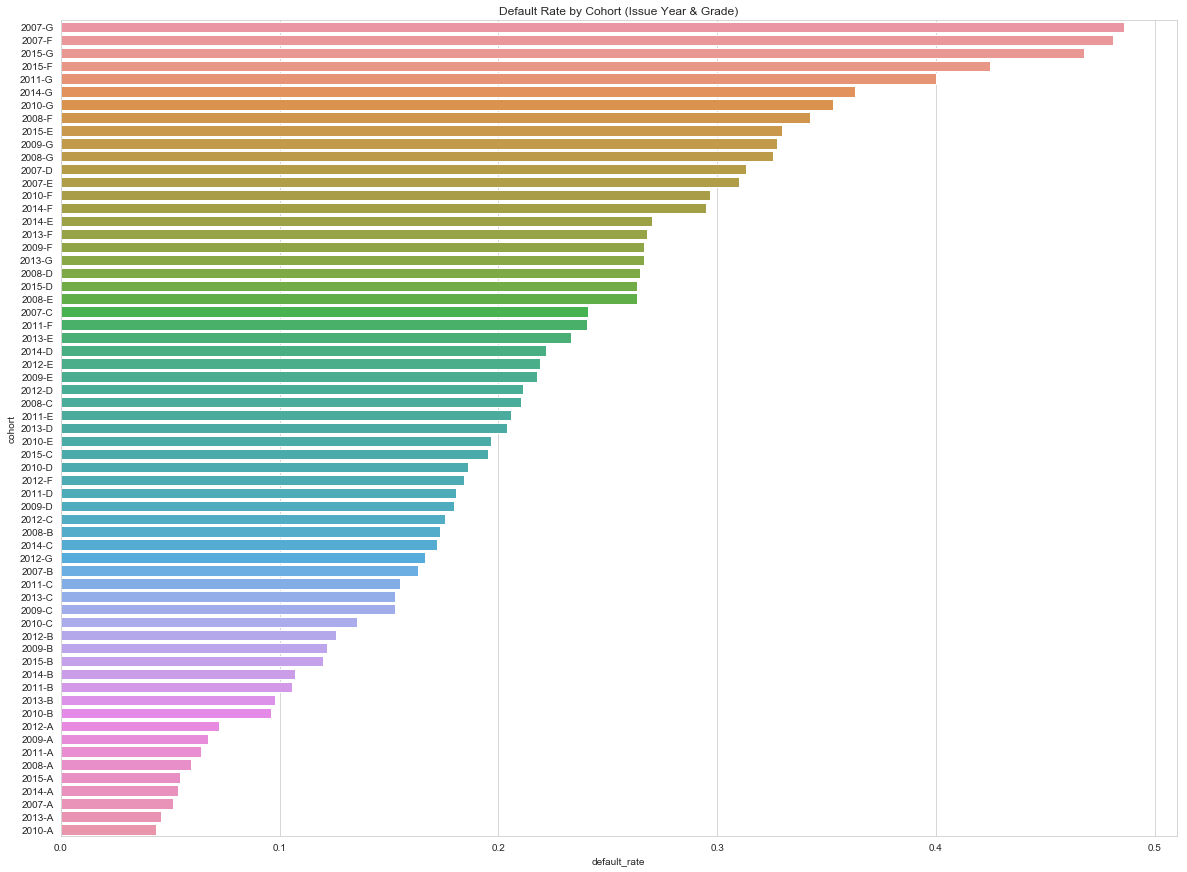

In [8]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
sns.barplot(y='cohort', x='default_rate', data=cohort_default_df)
plt.title('Default Rate by Cohort (Issue Year & Grade)');

In [9]:
cohort_default_analysis(data, ['issue_year'])

,issue_year,default_status,default_rate,cohort_size
0,2007,1,0.262023,603
1,2008,1,0.207271,2393
8,2015,1,0.149619,283173
7,2014,1,0.137264,162570
2,2009,1,0.136906,5281
5,2012,1,0.135795,43470
6,2013,1,0.123260,100422
3,2010,1,0.109218,9156
4,2011,1,0.106305,14101


In [10]:
cohort_default_analysis(data, ['grade'])

,grade,default_status,default_rate,cohort_size
6,G,1,0.390671,686
5,F,1,0.330423,4467
4,E,1,0.285950,21843
3,D,1,0.234066,76692
2,C,1,0.179708,162436
1,B,1,0.112482,212025
0,A,1,0.054950,143020


#### 2.3 When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average?

In [11]:
data['annualized_ror'].mean()

0.018966583467686184

In [12]:
def annualized_ror_analysis(data: pd.DataFrame, cohort_features: list):
    
    cohorts = data.groupby(cohort_features)
    
    cohort_return_df = cohorts['annualized_ror'].mean()\
    .to_frame()\
    .reset_index()\
    .merge(
        cohorts['annualized_ror']\
            .count()\
            .to_frame()\
            .rename(columns={'annualized_ror': 'cohort_size'})\
            .reset_index(),
        on = cohort_features)\
    .sort_values(by='annualized_ror', ascending=False)
    return cohort_return_df

In [13]:
cohort_return_df = annualized_ror_analysis(data, ['issue_year', 'grade'])\
    .assign(cohort = lambda x: x['issue_year'].apply(str) + '-' + x['grade'])

cohort_return_df.head(n=10)

,issue_year,grade,annualized_ror,cohort_size,cohort
41,2012,G,0.043012,24,2012-G
40,2012,F,0.033400,103,2012-F
39,2012,E,0.032345,795,2012-E
44,2013,C,0.030388,24693,2013-C
43,2013,B,0.030172,40313,2013-B
46,2013,E,0.028680,3231,2013-E
45,2013,D,0.028380,14505,2013-D
0,2007,A,0.027156,78,2007-A
50,2014,B,0.025857,53460,2014-B
32,2011,E,0.025079,272,2011-E


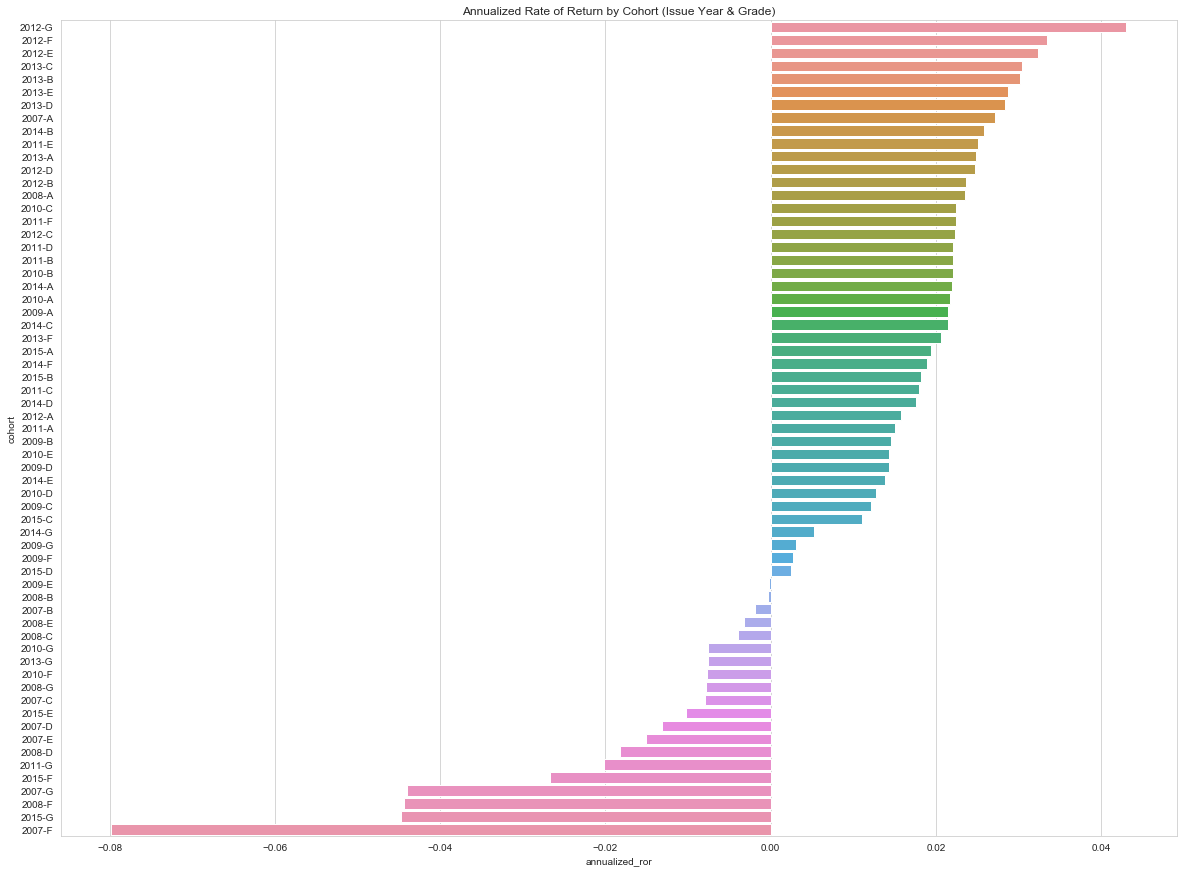

In [14]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
sns.barplot(y='cohort', x='annualized_ror', data=cohort_return_df)
plt.title('Annualized Rate of Return by Cohort (Issue Year & Grade)');

In [15]:
annualized_ror_analysis(data, ['issue_year'])

,issue_year,annualized_ror,cohort_size
6,2013,0.028955,100422
7,2014,0.022135,162570
5,2012,0.021753,43470
3,2010,0.020056,9156
4,2011,0.018650,14101
2,2009,0.014247,5281
8,2015,0.013507,283173
1,2008,-0.003826,2393
0,2007,-0.012745,603


In [16]:
annualized_ror_analysis(data, ['grade'])

,grade,annualized_ror,cohort_size
1,B,0.022876,212025
0,A,0.020328,143020
2,C,0.017700,162436
3,D,0.013345,76692
4,E,0.005861,21843
5,F,0.001999,4467
6,G,-0.017103,686
